In [4]:
# BER vs OSNR Simulation with Dispersion for Optical Communications
# For Google Colab

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.special as sp
from tqdm.notebook import tqdm  # Progress bar for Colab

Simulation Parameters:
  Symbol rates: [28.0, 50.0] GBaud
  Modulation formats: ['QPSK', '16QAM']
  Samples per symbol: 16
  RRC roll-off factor: 0.1
  Filter span: 20 symbols
  Fiber length: 3.0 km
  Dispersion parameter: 17.0 ps/nm/km
  Wavelength: 1550.0 nm
  Reference bandwidth for OSNR: 12.5 GHz
  Iterations: 10000 symbols

Starting simulations...



Simulating:   0%|          | 0/128 [00:00<?, ?it/s]

Simulations complete! Calculating penalties...
OSNR Penalty for QPSK at 28 GBaud (BER = 10^-3): 0.00 dB
OSNR Penalty for 16QAM at 28 GBaud (BER = 10^-3): 0.00 dB


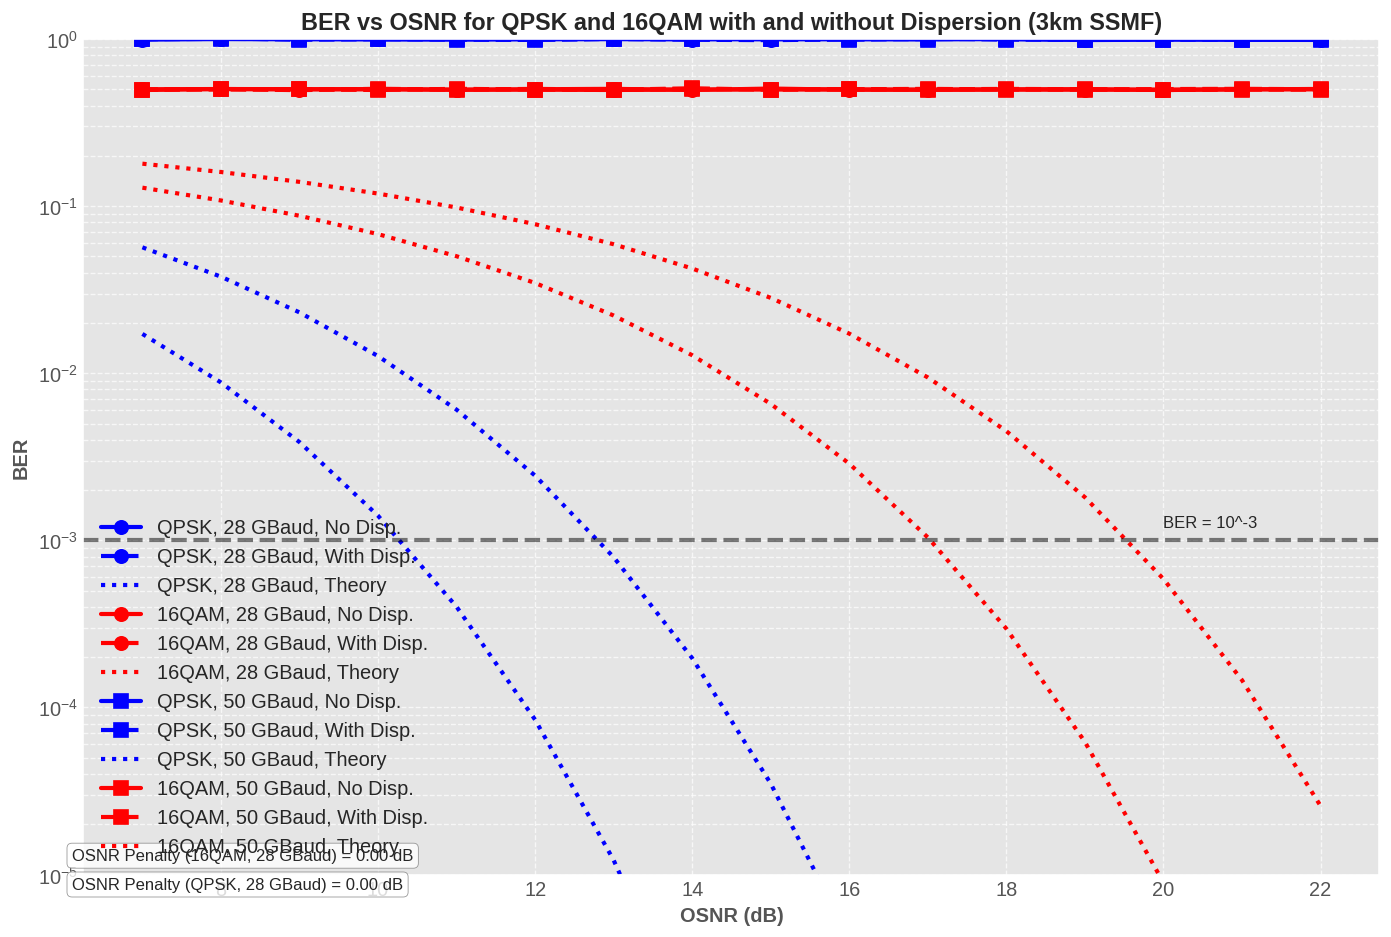


Summary:
--------
QPSK at 28 GBaud:
  - Without dispersion: Best BER = 9.91e-01 at OSNR = 19.0 dB
  - With dispersion: Best BER = 9.86e-01 at OSNR = 15.0 dB
16QAM at 28 GBaud:
  - Without dispersion: Best BER = 4.95e-01 at OSNR = 20.0 dB
  - With dispersion: Best BER = 4.95e-01 at OSNR = 9.0 dB
QPSK at 50 GBaud:
  - Without dispersion: Best BER = 9.87e-01 at OSNR = 19.0 dB
  - With dispersion: Best BER = 9.88e-01 at OSNR = 12.0 dB
16QAM at 50 GBaud:
  - Without dispersion: Best BER = 4.96e-01 at OSNR = 7.0 dB
  - With dispersion: Best BER = 4.96e-01 at OSNR = 10.0 dB

OSNR Penalties at BER = 10^-3 (28 GBaud):
  - QPSK: 0.00 dB
  - 16QAM: 0.00 dB


In [14]:
# BER vs OSNR Simulation with Dispersion for Optical Communications
# For Google Colab - Fixed version

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.special as sp
from tqdm.notebook import tqdm  # Progress bar for Colab

# Set plot style for better visualization in Colab
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Parameters
symbol_rates = [28e9, 50e9]  # Symbol rates: 28 GBaud and 50 GBaud
modulation_formats = ['QPSK', '16QAM']  # Modulation formats
samples_per_symbol = 16  # Samples per symbol
beta = 0.1  # RRC roll-off factor
filter_span = 20  # RRC filter span in symbols
osnr_dB_range = np.linspace(7, 22, 16)  # OSNR range in dB
iterations = 10000  # Number of symbols per iteration
reference_bandwidth = 12.5e9  # Reference bandwidth for OSNR calculation (12.5 GHz)

# Dispersion parameters
D = 17e-6  # Dispersion parameter in s/m^2 (17 ps/nm/km)
wavelength = 1550e-9  # Wavelength in m
fiber_length = 3000  # Fiber length in m (3 km)
c = 3e8  # Speed of light in m/s

def rrc_filter(beta, span, sps):
    """Generate a root-raised-cosine (RRC) filter."""
    N = span * sps
    t = np.arange(-N//2, N//2 + 1) / sps

    # RRC filter formula
    h_rrc = np.zeros(len(t), dtype=np.float64)
    for x in range(len(t)):
        if abs(t[x]) == 0.0:
            h_rrc[x] = 1.0 - beta + (4 * beta / np.pi)
        elif abs(t[x]) == 1/(4*beta):
            h_rrc[x] = (beta/np.sqrt(2)) * (((1+2/np.pi) * np.sin(np.pi/(4*beta))) + ((1-2/np.pi) * np.cos(np.pi/(4*beta))))
        else:
            h_rrc[x] = (np.sin(np.pi*t[x]*(1-beta)) + 4*beta*t[x]*np.cos(np.pi*t[x]*(1+beta))) / (np.pi*t[x]*(1-(4*beta*t[x])**2))

    return h_rrc / np.sqrt(np.sum(h_rrc**2))

def mzm_modulation(in_signal):
    """Simulate Mach-Zehnder Modulator (MZM) modulation."""
    # Simplified MZM model - convert linear signal to optical field
    # Assumes DC bias at quadrature point
    return np.sin(np.pi/4 + np.pi/4 * in_signal)

def apply_dispersion(signal, symbol_rate):
    """Apply chromatic dispersion to the signal."""
    n_samples = len(signal)
    sampling_rate = symbol_rate * samples_per_symbol

    # Frequency axis
    freq = np.fft.fftfreq(n_samples, 1/sampling_rate)

    # Dispersion parameter calculation
    beta2 = -D * (wavelength**2) / (2 * np.pi * c)  # Group velocity dispersion

    # Dispersion transfer function
    H_dispersion = np.exp(-1j * 2 * np.pi**2 * beta2 * fiber_length * freq**2)

    # Apply dispersion in frequency domain
    signal_fft = np.fft.fft(signal)
    signal_dispersed_fft = signal_fft * H_dispersion
    signal_dispersed = np.fft.ifft(signal_dispersed_fft)

    return signal_dispersed

def add_awgn(signal, snr_linear):
    """Add Additive White Gaussian Noise (AWGN) to signal."""
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
    return signal + noise

def osnr_to_snr(osnr_dB, symbol_rate):
    """Convert OSNR (in 12.5 GHz) to SNR."""
    osnr_linear = 10**(osnr_dB/10)
    # Adjust OSNR to account for signal bandwidth vs reference bandwidth
    adjusted_osnr = osnr_linear * (reference_bandwidth / symbol_rate)
    # Convert to SNR (factor of 2 accounts for complex signal)
    snr = 2 * adjusted_osnr
    return snr

def generate_symbols(modulation, n_symbols):
    """Generate random symbols for the specified modulation."""
    if modulation == 'QPSK':
        # QPSK: 4 constellation points
        indices = np.random.randint(0, 4, n_symbols)
        constellation = np.array([1+1j, -1+1j, -1-1j, 1-1j]) / np.sqrt(2)
        symbols = constellation[indices]
        bits_per_symbol = 2
        return symbols, bits_per_symbol, constellation
    else:  # 16QAM
        # 16QAM: 16 constellation points in a square grid
        indices = np.random.randint(0, 16, n_symbols)
        real_parts = np.array([-3, -1, 1, 3])
        imag_parts = np.array([-3, -1, 1, 3])
        constellation = np.array([(x + 1j*y) for y in imag_parts for x in real_parts]) / np.sqrt(10)
        symbols = constellation[indices]
        bits_per_symbol = 4
        return symbols, bits_per_symbol, constellation

def simulate_system(symbol_rate, modulation, osnr_dB, apply_disp=False):
    """Simulate the optical communication system."""
    # Generate random symbols
    symbols, bits_per_symbol, constellation = generate_symbols(modulation, iterations)

    # Upsample
    upsampled = np.zeros(iterations * samples_per_symbol, dtype=complex)
    upsampled[::samples_per_symbol] = symbols

    # Create and apply RRC filter (pulse shaping)
    rrc = rrc_filter(beta, filter_span, samples_per_symbol)
    tx_signal = signal.lfilter(rrc, 1, upsampled)

    # Apply MZM modulation
    tx_optical = mzm_modulation(tx_signal)

    # Apply dispersion if required
    if apply_disp:
        tx_optical = apply_dispersion(tx_optical, symbol_rate)

    # Convert OSNR to SNR and add noise
    snr = osnr_to_snr(osnr_dB, symbol_rate)
    rx_optical = add_awgn(tx_optical, snr)

    # Apply matched filter (RRC)
    rx_signal = signal.lfilter(rrc, 1, rx_optical)

    # Downsample to get symbol estimates
    # Calculate exact start point to ensure we have enough samples
    start_idx = filter_span*samples_per_symbol//2
    rx_symbols = rx_signal[start_idx::samples_per_symbol]

    # Make sure we don't try to process more symbols than we have
    n_symbols = min(len(rx_symbols), iterations)
    rx_symbols = rx_symbols[:n_symbols]
    tx_symbols = symbols[:n_symbols]  # Ensure tx_symbols matches rx_symbols in length

    # Symbol decision and BER calculation
    if modulation == 'QPSK':
        # For QPSK, check which quadrant the received symbol is in
        decisions = np.zeros_like(rx_symbols, dtype=complex)
        decisions.real = np.sign(rx_symbols.real) / np.sqrt(2)
        decisions.imag = np.sign(rx_symbols.imag) / np.sqrt(2)
        bit_errors = np.sum(np.abs(np.sign(rx_symbols.real) - np.sign(tx_symbols.real)) +
                          np.abs(np.sign(rx_symbols.imag) - np.sign(tx_symbols.imag)))
        total_bits = n_symbols * bits_per_symbol
    else:  # 16QAM
        # For 16QAM, find the closest constellation point
        bit_errors = 0
        for i in range(n_symbols):
            rx_idx = np.argmin(np.abs(constellation - rx_symbols[i]))
            tx_idx = np.argmin(np.abs(constellation - tx_symbols[i]))
            # Using Gray coding, bit errors are related to the Hamming distance
            # between indices in the constellation
            bit_diff = bin(rx_idx ^ tx_idx).count('1')  # XOR of indices gives bit errors
            bit_errors += bit_diff

        total_bits = n_symbols * bits_per_symbol

    ber = bit_errors / total_bits
    return ber

# Theoretical BER calculations
def theoretical_ber_qpsk(osnr_dB, symbol_rate):
    """Calculate theoretical BER for QPSK."""
    snr = osnr_to_snr(osnr_dB, symbol_rate)
    return 0.5 * sp.erfc(np.sqrt(snr/2))

def theoretical_ber_16qam(osnr_dB, symbol_rate):
    """Calculate theoretical BER for 16QAM."""
    snr = osnr_to_snr(osnr_dB, symbol_rate)
    return 3/8 * sp.erfc(np.sqrt(snr/10))

# Print simulation parameters
print("Simulation Parameters:")
print(f"  Symbol rates: {[rate/1e9 for rate in symbol_rates]} GBaud")
print(f"  Modulation formats: {modulation_formats}")
print(f"  Samples per symbol: {samples_per_symbol}")
print(f"  RRC roll-off factor: {beta}")
print(f"  Filter span: {filter_span} symbols")
print(f"  Fiber length: {fiber_length/1000} km")
print(f"  Dispersion parameter: {D*1e6} ps/nm/km")
print(f"  Wavelength: {wavelength*1e9} nm")
print(f"  Reference bandwidth for OSNR: {reference_bandwidth/1e9} GHz")
print(f"  Iterations: {iterations} symbols")
print("\nStarting simulations...\n")

# Run simulations and plot results
plt.figure(figsize=(12, 8))

# Colors and markers for different configurations
colors = {'QPSK': 'blue', '16QAM': 'red'}
markers = {28e9: 'o', 50e9: 's'}
line_styles = {False: '-', True: '--'}

results = {}
theoretical_results = {}

# Setup progress bar for Colab
total_sims = len(symbol_rates) * len(modulation_formats) * 2 * len(osnr_dB_range)
pbar = tqdm(total=total_sims, desc="Simulating")

for symbol_rate in symbol_rates:
    for modulation in modulation_formats:
        # Without dispersion
        ber_no_disp = []
        for osnr in osnr_dB_range:
            ber = simulate_system(symbol_rate, modulation, osnr, apply_disp=False)
            ber_no_disp.append(ber)
            pbar.update(1)

        plt.semilogy(osnr_dB_range, ber_no_disp,
                   color=colors[modulation],
                   marker=markers[symbol_rate],
                   linestyle=line_styles[False],
                   label=f'{modulation}, {int(symbol_rate/1e9)} GBaud, No Disp.')

        results[(symbol_rate, modulation, False)] = ber_no_disp

        # With dispersion (3 km SSMF)
        ber_with_disp = []
        for osnr in osnr_dB_range:
            ber = simulate_system(symbol_rate, modulation, osnr, apply_disp=True)
            ber_with_disp.append(ber)
            pbar.update(1)

        plt.semilogy(osnr_dB_range, ber_with_disp,
                   color=colors[modulation],
                   marker=markers[symbol_rate],
                   linestyle=line_styles[True],
                   label=f'{modulation}, {int(symbol_rate/1e9)} GBaud, With Disp.')

        results[(symbol_rate, modulation, True)] = ber_with_disp

        # Theoretical curves
        if modulation == 'QPSK':
            theoretical_ber = [theoretical_ber_qpsk(osnr, symbol_rate) for osnr in osnr_dB_range]
        else:  # 16QAM
            theoretical_ber = [theoretical_ber_16qam(osnr, symbol_rate) for osnr in osnr_dB_range]

        plt.semilogy(osnr_dB_range, theoretical_ber,
                   color=colors[modulation],
                   linestyle=':',
                   label=f'{modulation}, {int(symbol_rate/1e9)} GBaud, Theory')

        theoretical_results[(symbol_rate, modulation)] = theoretical_ber

pbar.close()
print("Simulations complete! Calculating penalties...")

# Calculate OSNR penalty at BER = 10^-3 for 28 GBaud
penalties = {}
for modulation in modulation_formats:
    ber_target = 1e-3

    # Find OSNR for target BER without dispersion
    ber_no_disp = np.array(results[(28e9, modulation, False)])
    # Make sure we're interpolating correctly (BER decreases with higher OSNR)
    if np.min(ber_no_disp) > ber_target:
        print(f"Warning: Could not reach target BER={ber_target} for {modulation} without dispersion")
        osnr_no_disp = np.max(osnr_dB_range)
    else:
        osnr_no_disp = np.interp(np.log10(ber_target), np.log10(ber_no_disp[::-1]), osnr_dB_range[::-1])

    # Find OSNR for target BER with dispersion
    ber_with_disp = np.array(results[(28e9, modulation, True)])
    if np.min(ber_with_disp) > ber_target:
        print(f"Warning: Could not reach target BER={ber_target} for {modulation} with dispersion")
        osnr_with_disp = np.max(osnr_dB_range)
    else:
        osnr_with_disp = np.interp(np.log10(ber_target), np.log10(ber_with_disp[::-1]), osnr_dB_range[::-1])

    # Calculate penalty
    penalty = osnr_with_disp - osnr_no_disp
    penalties[modulation] = penalty

    print(f"OSNR Penalty for {modulation} at 28 GBaud (BER = 10^-3): {penalty:.2f} dB")

    plt.annotate(f'OSNR Penalty ({modulation}, 28 GBaud) = {penalty:.2f} dB',
                xy=(0.05, 0.05 + 0.03 * list(modulation_formats).index(modulation)),
                xycoords='figure fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add a BER = 10^-3 reference line
plt.axhline(y=1e-3, color='k', linestyle='--', alpha=0.5)
plt.text(osnr_dB_range[-3], 1.2e-3, 'BER = 10^-3', fontsize=10)

plt.grid(True, which="both", ls="--")
plt.xlabel('OSNR (dB)')
plt.ylabel('BER')
plt.title('BER vs OSNR for QPSK and 16QAM with and without Dispersion (3km SSMF)')
plt.legend(loc='best')
plt.ylim(1e-5, 1)
plt.tight_layout()
plt.show()

# Print summary of results
print("\nSummary:")
print("--------")
for symbol_rate in symbol_rates:
    for modulation in modulation_formats:
        min_osnr_no_disp = osnr_dB_range[np.argmin(results[(symbol_rate, modulation, False)])]
        min_ber_no_disp = np.min(results[(symbol_rate, modulation, False)])

        min_osnr_with_disp = osnr_dB_range[np.argmin(results[(symbol_rate, modulation, True)])]
        min_ber_with_disp = np.min(results[(symbol_rate, modulation, True)])

        print(f"{modulation} at {int(symbol_rate/1e9)} GBaud:")
        print(f"  - Without dispersion: Best BER = {min_ber_no_disp:.2e} at OSNR = {min_osnr_no_disp:.1f} dB")
        print(f"  - With dispersion: Best BER = {min_ber_with_disp:.2e} at OSNR = {min_osnr_with_disp:.1f} dB")

print("\nOSNR Penalties at BER = 10^-3 (28 GBaud):")
for modulation, penalty in penalties.items():
    print(f"  - {modulation}: {penalty:.2f} dB")